In [266]:
# from scikeras.wrappers import KerasClassifier

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import sweetviz as sv
import plotly.graph_objs as pg
import plotly.figure_factory as ffc
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [267]:
 #-----------SPRACOVANIE DAT--------------#

df = pd.read_csv("weather_data.csv")
test_data = pd.read_csv("weather_data.csv")

# najskor pridam do irradiance vsade 0 aby sa neodstranilo prilis vela zaznamov

df["Irradiance"] = df["Irradiance"].fillna(0.0)

# zistili sme ze v nasom datasete sa nachádza 277 null hodnôt okrem (stlpca Irradiance)
# pre dataset nasich rozmerov je to pomerne mali pocet zaznamov a preto sme sa 
# ich rozhodli odstranit
print(f"There are: {df.isnull().sum().sum()} null values in dataset")

# Konvertovanie stĺpca 'UV Index' na číselný typ
df['UV Index'] = pd.to_numeric(df['UV Index'], errors='coerce')


print(df.isnull().sum())

# odstranenie prazdnych zaznamov

df = df.dropna()
df = df.drop_duplicates(keep='first')
df = df.fillna(0)

df = df.drop('Irradiance', axis=1)




There are: 277 null values in dataset
Temperature             44
Humidity                35
Wind Speed              38
Precipitation (%)       33
Cloud Cover              0
Atmospheric Pressure    44
UV Index                37
Season                   0
Visibility (km)         47
Location                 0
Weather Type             0
Irradiance               0
dtype: int64


In [268]:
# zistenie kolko roznych druhov Cloud Cover sa nachadza v DB a ich zakodovnie
# Cloud Cover sme si vybrali druh kodovanie: Label Encoding 

unique_values_cloud = df['Cloud Cover'].unique()
print(f"Unique words: {unique_values_cloud}")
print(f"Number of unique words cloud: {len(unique_values_cloud)}")

df['Cloud Cover'] = pd.factorize(df['Cloud Cover'])[0]

unique_values_location = df['Location'].unique()
print(f"Unique words: {unique_values_location}")
print(f"Number of unique words location: {len(unique_values_location)}")

df['Location'] = pd.factorize(df['Location'])[0]

# na stlpec season sme vybrali druh zakódovania One-Hot Encoding

df_one_hot = pd.get_dummies(df['Season'], prefix='Season')
df = pd.concat([df, df_one_hot], axis = 1)

df = df.drop(columns=['Season'])


df['Season_Winter'] = pd.to_numeric(df['Season_Winter'], errors='coerce')
df['Season_Summer'] = pd.to_numeric(df['Season_Summer'], errors='coerce')
df['Season_Autumn'] = pd.to_numeric(df['Season_Autumn'], errors='coerce')
df['Season_Spring'] = pd.to_numeric(df['Season_Spring'], errors='coerce')

# Zobrazenie dátových typov každého stĺpca
print(df.dtypes)

# Vyfiltrovanie stĺpcov, ktoré nie sú číselného typu (float alebo int)
non_numeric_columns = df.select_dtypes(exclude=['int64', 'float64']).columns
print("Stĺpce, ktoré nie sú číselného typu:", non_numeric_columns)



Unique words: ['partly cloudy' 'clear' 'overcast' 'cloudy']
Number of unique words cloud: 4
Unique words: ['inland' 'mountain' 'coastal' 'island']
Number of unique words location: 4
Temperature             float64
Humidity                float64
Wind Speed              float64
Precipitation (%)       float64
Cloud Cover               int64
Atmospheric Pressure    float64
UV Index                float64
Visibility (km)         float64
Location                  int64
Weather Type             object
Season_Autumn             uint8
Season_Spring             uint8
Season_Summer             uint8
Season_Winter             uint8
dtype: object
Stĺpce, ktoré nie sú číselného typu: Index(['Weather Type', 'Season_Autumn', 'Season_Spring', 'Season_Summer',
       'Season_Winter'],
      dtype='object')


In [269]:
# Vyhľadanie duplicitných záznamov

duplicate = df[df.duplicated()]
df = df.drop_duplicates()
print("Number of records in dataset: "+str(len(df)))
print("There are: " + str(len(duplicate)) + " duplicates.")



Number of records in dataset: 12924
There are: 0 duplicates.


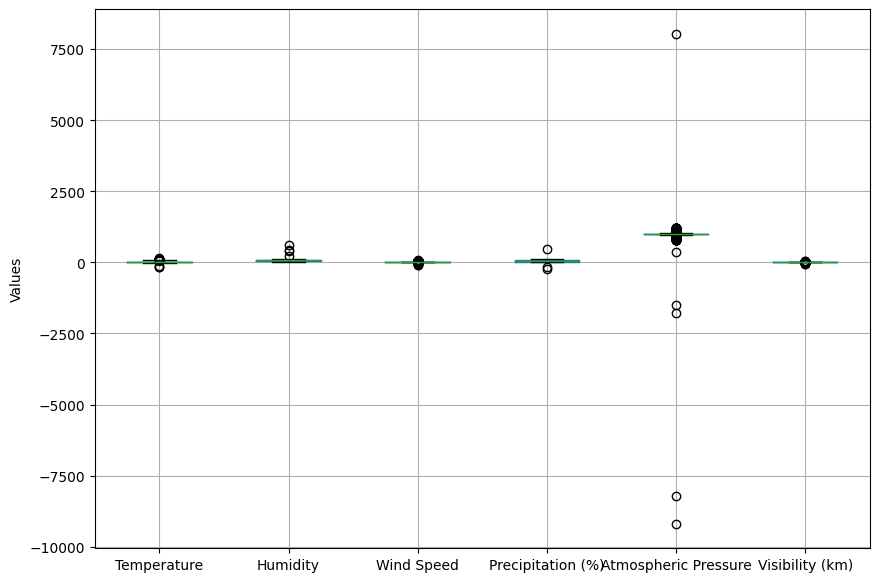

In [270]:
# Teraz potrebujeme odstrániť outliery v stĺpcos v ktorých boli originálne numerické hodnoty

numeric_columns = ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)'
                   , 'Atmospheric Pressure', 'Visibility (km)'
                  ]

# vypisanie hodnot ako boxplot
df.boxplot(column=['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)'
                   , 'Atmospheric Pressure', 'Visibility (km)'],figsize=(10,7))
plt.ylabel("Values")
plt.show()

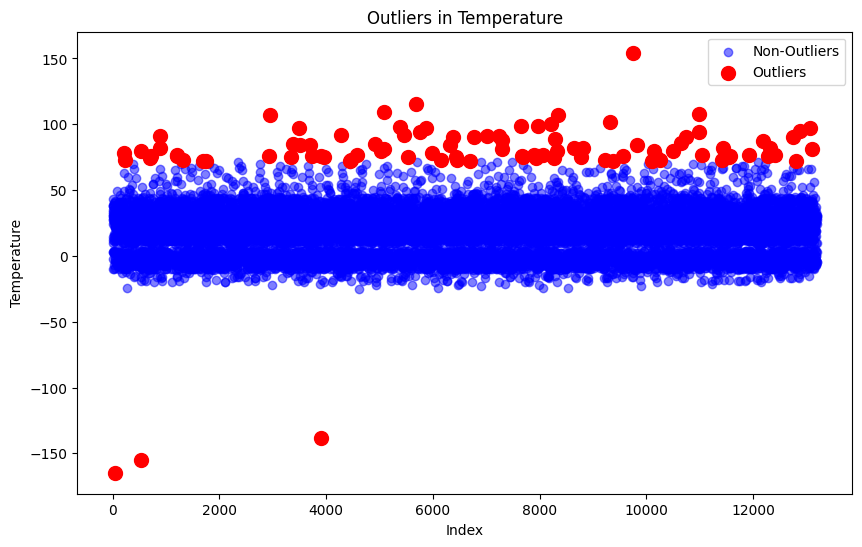

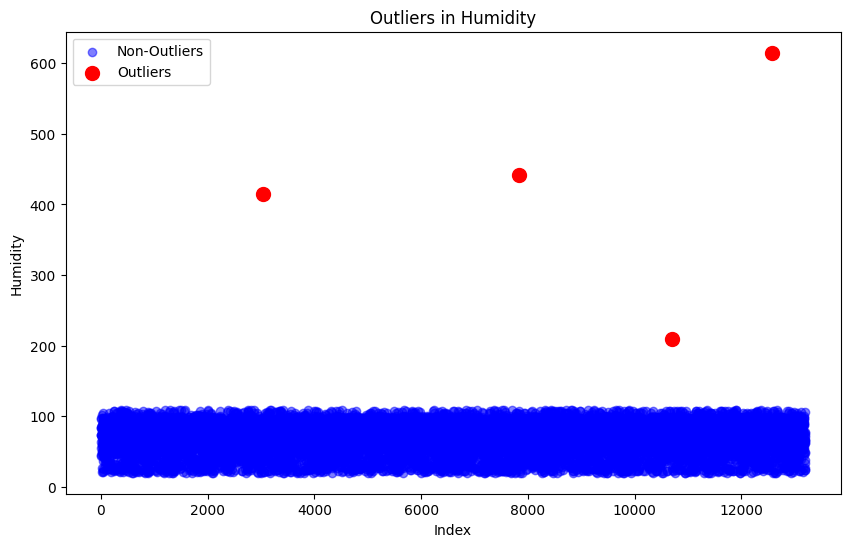

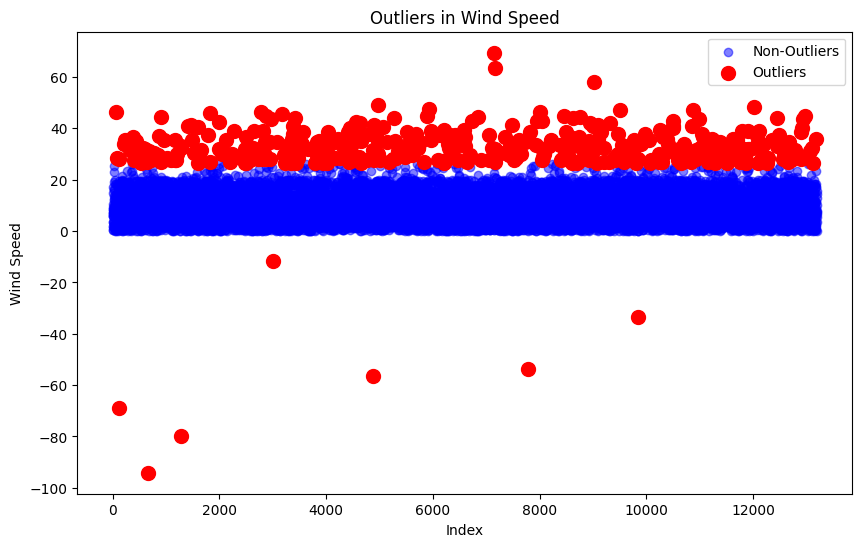

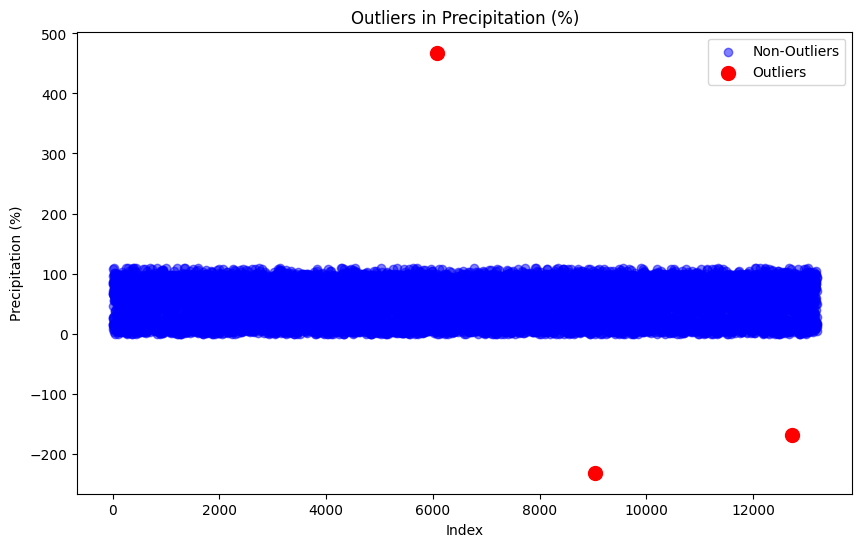

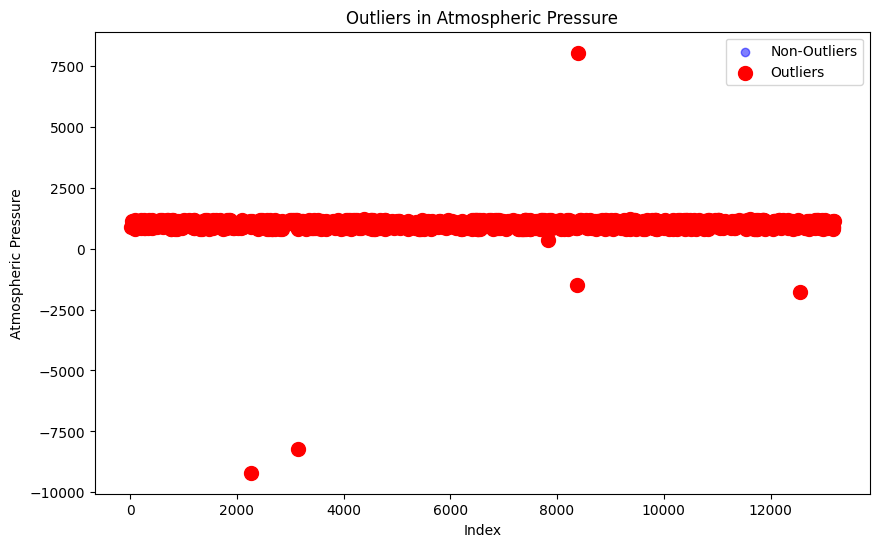

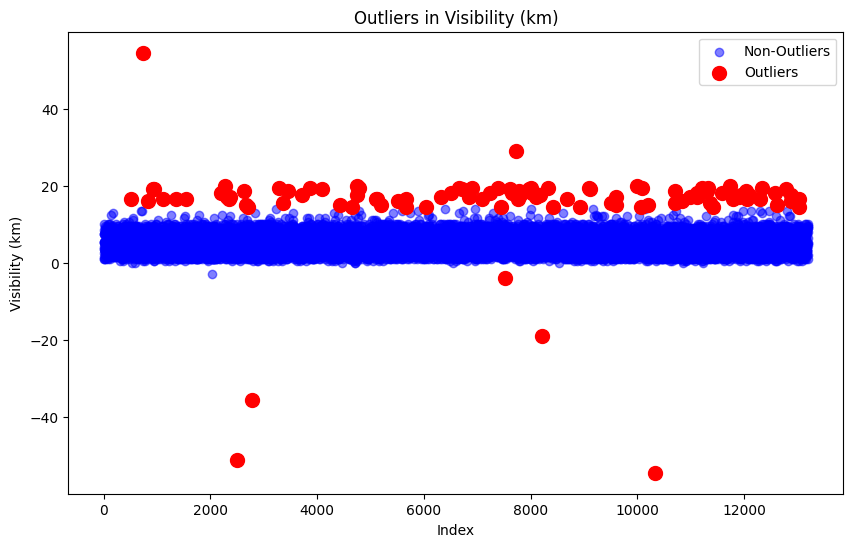

        Temperature      Humidity    Wind Speed  Precipitation (%)  \
count  11103.000000  11103.000000  11103.000000       11103.000000   
mean      18.945778     69.004864      9.116545          50.973460   
std       15.680294     19.115083      5.531784          31.715426   
min      -24.000000     20.000000      0.000000           0.000000   
25%        7.000000     59.000000      5.000000          18.000000   
50%       22.000000     70.000000      8.500000          54.000000   
75%       30.000000     83.000000     13.000000          80.000000   
max       71.000000    100.000000     26.000000         100.000000   

        Cloud Cover  Atmospheric Pressure      UV Index  Visibility (km)  \
count  11103.000000          11103.000000  11103.000000     11103.000000   
mean       1.128884           1006.235808      3.367829         5.124109   
std        0.905187             12.884447      3.302797         2.592008   
min        0.000000            962.880000      0.000000        -3

In [271]:

# Identifikovanie a odstraňovanie outlierov na základe IQR
def detect_and_remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identifikácia outlierov
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    # Odstránenie outlierov
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df_clean, outliers

# Aplikovanie na všetky číselné stĺpce
for column in numeric_columns:
    df, outliers = detect_and_remove_outliers(df, column)
    
    # Vizualizácia výsledkov
    plt.figure(figsize=(10, 6))
    
    plt.scatter(df.index, df[column], color='blue', label='Non-Outliers', alpha=0.5)
    plt.scatter(outliers.index, outliers[column], color='red', label='Outliers', s=100)
    
    plt.title(f"Outliers in {column}")
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.legend()
    plt.show()

# Oprava neplatných hodnôt
df['Humidity'] = df['Humidity'].clip(lower=0, upper=100)
df['Precipitation (%)'] = df['Precipitation (%)'].clip(lower=0, upper=100)
# Odstrániť riadky, kde je UV Index väčší ako realistická maximálna hodnota
df = df[df['UV Index'] <= 11]
df = df[df['UV Index'] >= 0]


# Kontrola dát
print(df.describe())


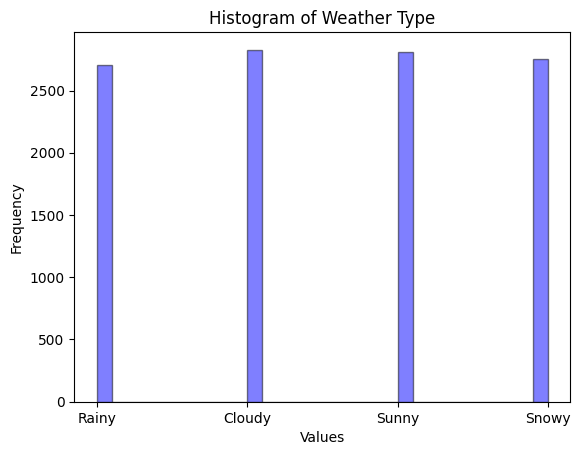

((7772, 13), (7772,), (1665, 13), (1665,), (1666, 13), (1666,))

In [272]:
X = df.drop(columns='Weather Type')
Y = df['Weather Type']

# Najprv rozdelíme dáta na trénovaciu a testovaciu množinu (60% tréning, 40% test)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)

# Potom rozdelíme trénovaciu množinu na tréningovú a validačnú množinu (50% tréning, 50% validačná)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp , Y_temp, test_size=0.50, random_state=42)

plt.hist(df['Weather Type'], bins=30, color='blue', edgecolor='black', alpha=0.5)

plt.title('Histogram of Weather Type')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.show()

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

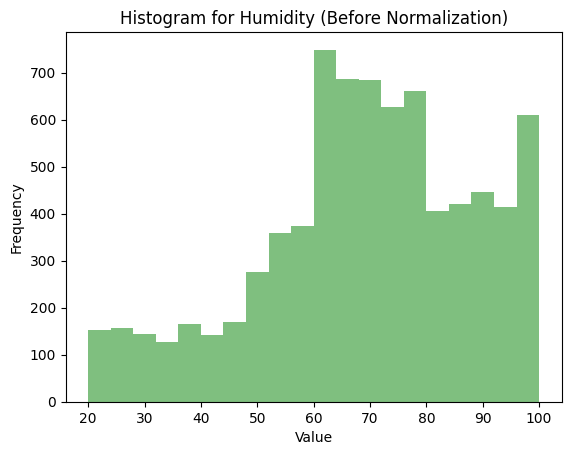

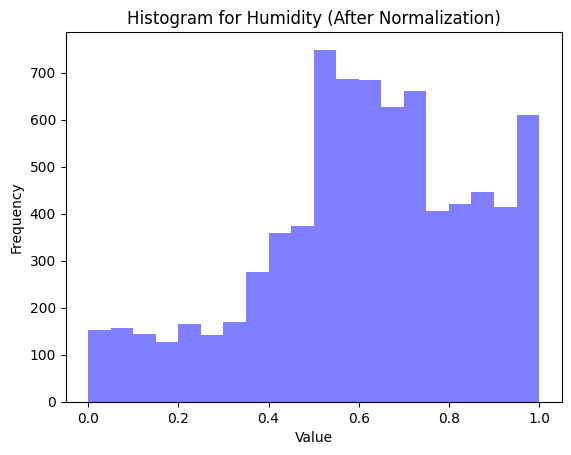

In [273]:
# Uloženie pôvodných dát pred normalizáciou
X_train_original = X_train.copy()  # Uložte pred aplikovaním MinMaxScaler

# Vytvorenie dátového rámca s názvami stĺpcov pre pôvodné dáta
X_train_original_df = pd.DataFrame(X_train_original, columns=X.columns)

# Zobrazenie histogramu pre stĺpec podľa názvu (napr. 'Humidity') pred normalizáciou
plt.hist(X_train_original_df['Humidity'], bins=20, color='green', alpha=0.5)
plt.title('Histogram for Humidity (Before Normalization)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


# Normalizácia dát
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Vytvorenie dátového rámca s názvami stĺpcov po normalizácii
X_train_df = pd.DataFrame(X_train, columns=X.columns)  # Uistite sa, že X má názvy stĺpcov

# Zobrazenie histogramu pre ten istý stĺpec po normalizácii (napr. 'Humidity')
plt.hist(X_train_df['Humidity'], bins=20, color='blue', alpha=0.5)
plt.title('Histogram for Humidity (After Normalization)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


model accuracy: 0.9411764705882353


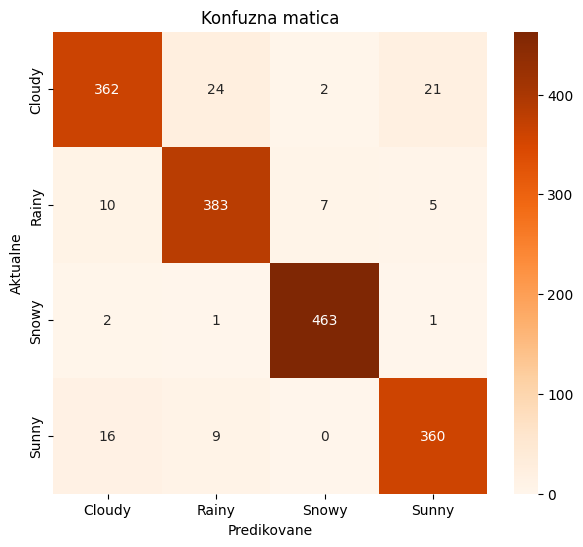

In [274]:
model = LogisticRegression(max_iter=200)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

accurracy = accuracy_score(Y_test, y_pred)
print(f"model accuracy: {accurracy}")

# toto su len testovacie data
conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Konfuzna matica")
plt.xlabel("Predikovane")
plt.ylabel("Aktualne")
plt.show()

# 60-20-20 model accuracy: 0.9302937308198159
# 70-15-15 model accuracy: 0.9298655756867329
# 50-25-25 model accuracy: 0.9284712482468443
# 80-10-10 model accuracy: 0.9414941494149415





In [275]:
# korelacna matica
corr_matrix = px.imshow(df.corr())
corr_matrix.show()

C:\Users\mraff\AppData\Local\Temp\ipykernel_27756\2365527316.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



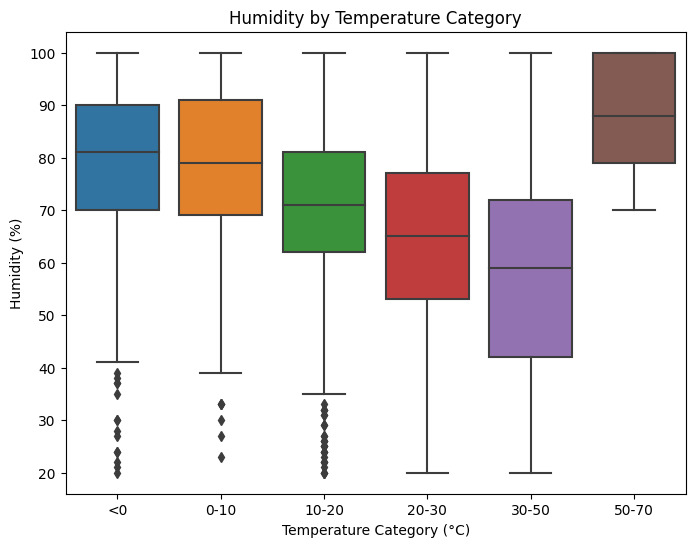

In [276]:
# 1. Teplota vs. Vlhkosť (box plot)

# Rozdelenie teploty do kategórií
df['Temperature Category'] = pd.cut(df['Temperature'], bins=[-30, 0, 10, 20, 30, 50, 70], labels=['<0', '0-10', '10-20', '20-30', '30-50', '50-70'])

plt.figure(figsize=(8,6))
sns.boxplot(x='Temperature Category', y='Humidity', data=df)
plt.title('Humidity by Temperature Category')
plt.xlabel('Temperature Category (°C)')
plt.ylabel('Humidity (%)')
plt.show()



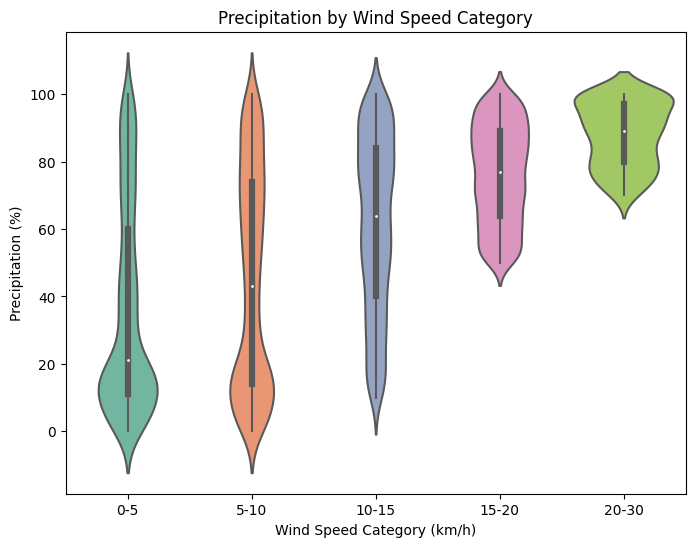

In [277]:
# 2. Vietor a Zrážky (violin plot)

df['Wind Speed Category'] = pd.cut(df['Wind Speed'], bins=[0, 5, 10, 15, 20, 30], labels=['0-5', '5-10', '10-15', '15-20', '20-30'])

plt.figure(figsize=(8,6))
sns.violinplot(x='Wind Speed Category', y='Precipitation (%)', data=df, palette='Set2')
plt.title('Precipitation by Wind Speed Category')
plt.xlabel('Wind Speed Category (km/h)')
plt.ylabel('Precipitation (%)')
plt.show()



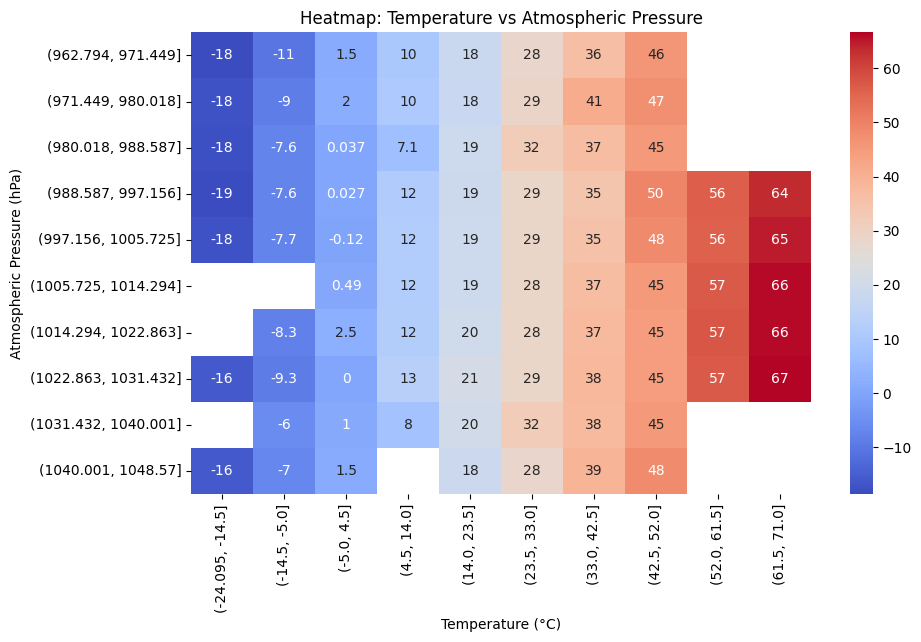

In [278]:
# 3. Atmosférický tlak vs. Teplota (heatmapa)

# Vytvárame mriežku pre atmosférický tlak a teplotu
pressure_temp = pd.pivot_table(df, values='Temperature', index=pd.cut(df['Atmospheric Pressure'], bins=10), columns=pd.cut(df['Temperature'], bins=10), aggfunc='mean')

plt.figure(figsize=(10,6))
sns.heatmap(pressure_temp, cmap='coolwarm', annot=True)
plt.title('Heatmap: Temperature vs Atmospheric Pressure')
plt.xlabel('Temperature (°C)')
plt.ylabel('Atmospheric Pressure (hPa)')
plt.show()


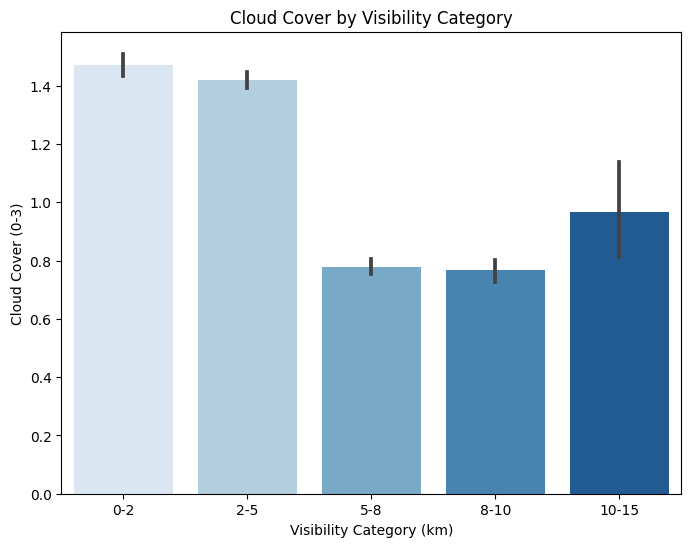

In [279]:
# 4. Oblačnosť vs. Viditeľnosť (bar plot)

# Rozdelenie viditeľnosti do kategórií
df['Visibility Category'] = pd.cut(df['Visibility (km)'], bins=[0, 2, 5, 8, 10, 15], labels=['0-2', '2-5', '5-8', '8-10', '10-15'])

plt.figure(figsize=(8,6))
sns.barplot(x='Visibility Category', y='Cloud Cover', data=df, palette='Blues')
plt.title('Cloud Cover by Visibility Category')
plt.xlabel('Visibility Category (km)')
plt.ylabel('Cloud Cover (0-3)')
plt.show()

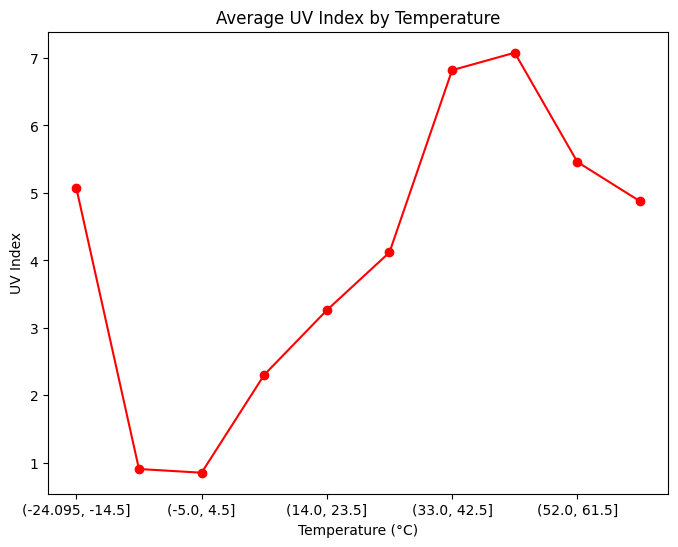

In [280]:
# 5. Teplota a UV Index (line plot)

# Priemerný UV Index pre teplotné kategórie
temp_uv = df.groupby(pd.cut(df['Temperature'], bins=10))['UV Index'].mean()

plt.figure(figsize=(8,6))
temp_uv.plot(kind='line', marker='o', color='red')
plt.title('Average UV Index by Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('UV Index')
plt.show()




In [281]:
# 1. Vytvorenie modelu na pretrénovanie
# Prevod Y na binárny formát
Y_train = pd.get_dummies(Y_train).values  # Konvertuje na binárny formát
Y_val = pd.get_dummies(Y_val).values
Y_test = pd.get_dummies(Y_test).values

# Kontrola tvaru Y
print(Y_train.shape)  # Tvar by mal byť (n_samples, n_classes)
print(Y_val.shape)
print(Y_test.shape)


(7772, 4)
(1665, 4)
(1666, 4)


Epoch 1/100


c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8222 - loss: 0.4822 - val_accuracy: 0.9441 - val_loss: 0.1772
Epoch 2/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.9436 - loss: 0.1924 - val_accuracy: 0.9646 - val_loss: 0.1222
Epoch 3/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.9550 - loss: 0.1456 - val_accuracy: 0.9520 - val_loss: 0.1470
Epoch 4/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9568 - loss: 0.1355 - val_accuracy: 0.9532 - val_loss: 0.1653
Epoch 5/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.9622 - loss: 0.1254 - val_accuracy: 0.9562 - val_loss: 0.1301
Epoch 6/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9638 - loss: 0.1180 - val_accuracy: 0.9754 - val_loss: 0.0923
Epoch 7/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.9637 - loss: 0.1138 - val_accuracy: 0.9706 - val_loss: 0.0872
Epoch 8/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9659 - loss: 0.1143 - val_accuracy

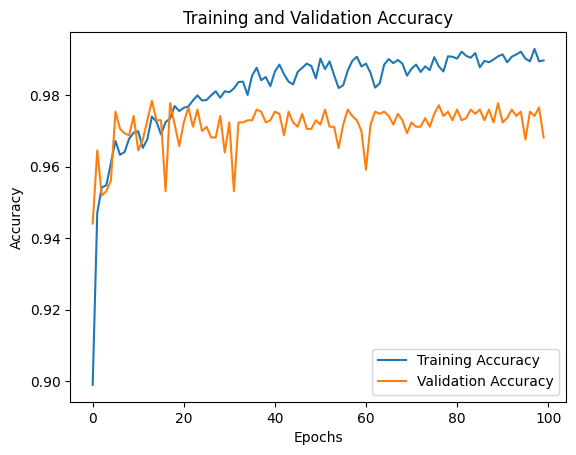

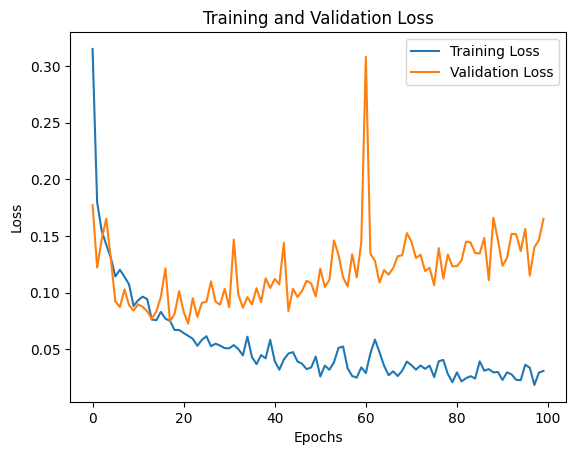

In [282]:

# Definícia modelu
def create_model():
    model = Sequential()
    model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(Y_train.shape[1], activation='softmax'))
    
    # Kompilácia modelu
    model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()

# Trénovanie modelu
history = model.fit(X_train, Y_train, epochs=100, validation_data=(X_val, Y_val), batch_size=32)

# Zobrazenie priebehu trénovania
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Zobrazenie straty
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [283]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f'Test accuracy: {test_accuracy}')

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.9750 - loss: 0.2545
Test accuracy: 0.9699879884719849


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


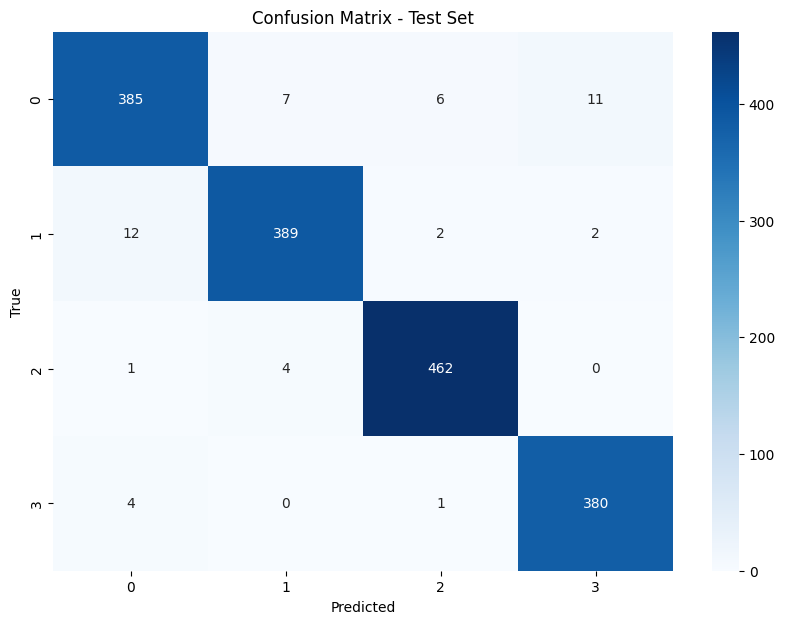

243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step


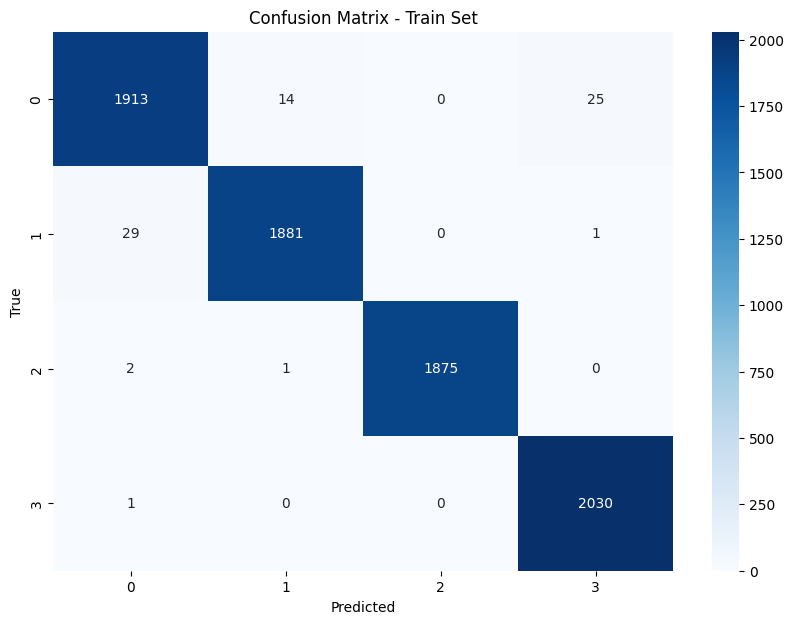

In [284]:
# Predpoveď na testovacích dátach
Y_pred_test = model.predict(X_test)
Y_pred_classes_test = Y_pred_test.argmax(axis=1)
Y_true_test = Y_test.argmax(axis=1)

# Vytvorenie konfúznej matice pre testovaciu množinu
conf_matrix_test = confusion_matrix(Y_true_test, Y_pred_classes_test)

# Vizuálne zobrazenie konfúznej matice pre testovaciu množinu
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Predpoveď na trénovacích dátach
Y_pred_train = model.predict(X_train)
Y_pred_classes_train = Y_pred_train.argmax(axis=1)
Y_true_train = Y_train.argmax(axis=1)

# Vytvorenie konfúznej matice pre trénovaciu množinu
conf_matrix_train = confusion_matrix(Y_true_train, Y_pred_classes_train)

# Vizuálne zobrazenie konfúznej matice pre trénovaciu množinu
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [298]:
'''
# Definícia modelu s Dropout
def create_model2():
    model = Sequential()
    
    # Prvá hustá vrstva s Dropout
    model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(0.3))  # Pridanie dropout s pravdepodobnosťou 0.3

    # Druhá hustá vrstva s Dropout
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))  # Pridanie dropout s pravdepodobnosťou 0.3

    # Výstupná vrstva
    model.add(Dense(Y_train.shape[1], activation='softmax'))
    
    # Kompilácia modelu
    model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


# N-fold cross-validation setup
n_splits = 5  # Počet folds pre cross-validáciu (napr. 5-fold CV)
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Uchovanie skóre pre každý fold
val_acc_per_fold = []
val_loss_per_fold = []

# Cross-validácia
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f'Fold {fold+1}/{n_splits}')
    
    # Rozdelenie dát pre aktuálny fold
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    Y_train_fold, Y_val_fold = Y_train[train_idx], Y_train[val_idx]
    
    # Vytvorenie nového modelu pre každý fold
    model = create_model()
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Trénovanie modelu pre aktuálny fold
    history = model.fit(X_train_fold, Y_train_fold, 
                        epochs=80, 
                        validation_data=(X_val_fold, Y_val_fold), 
                        batch_size=32, 
                        callbacks=[early_stopping],
                        verbose=0)  # verbose=0 na vypnutie výpisov

    # Uloženie výsledkov pre aktuálny fold
    val_acc_per_fold.append(max(history.history['val_accuracy']))
    val_loss_per_fold.append(min(history.history['val_loss']))

    print(f"Fold {fold+1} - Validation Accuracy: {max(history.history['val_accuracy'])}, Validation Loss: {min(history.history['val_loss'])}")
    
    # Zobrazenie priebehu trénovania a validácie pre aktuálny fold
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy - Fold {fold+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Zobrazenie straty pre aktuálny fold
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss - Fold {fold+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Výsledky N-fold cross-validácie
print(f'\nPriemerná validácia presnosti cez všetky folds: {np.mean(val_acc_per_fold)}')
print(f'Priemerná validácia straty cez všetky folds: {np.mean(val_loss_per_fold)}')

# Vizualizácia validácie presnosti pre každý fold
plt.plot(val_acc_per_fold, label='Validation Accuracy per Fold')
plt.title('Validation Accuracy for each Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Vizualizácia validácie straty pre každý fold
plt.plot(val_loss_per_fold, label='Validation Loss per Fold')
plt.title('Validation Loss for each Fold')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()
plt.show()

'''
# Definícia modelu s Dropout a parametrami pre neuróny a learning rate
def create_model2(n_neurons_1, n_neurons_2, learning_rate):
    model = Sequential()
    
    # Prvá vrstva s Dropout
    model.add(Dense(n_neurons_1, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(0.3))  # Dropout v prvej vrstve

    # Druhá vrstva s Dropout
    model.add(Dense(n_neurons_2, activation='relu'))
    model.add(Dropout(0.3))  # Dropout v druhej vrstve

    # Výstupná vrstva
    model.add(Dense(Y_train.shape[1], activation='softmax'))
    
    # Kompilácia modelu
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# N-fold cross-validation setup
n_splits = 5  # Počet folds pre cross-validáciu
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Grid search parametre
epochs_options = [50, 70]
learning_rate_options = [0.01, 0.001]
neurons_1_options = [64, 32]
neurons_2_options = [32, 16]

# Uchovanie najlepšieho skóre a parametrov
best_score = -np.inf
best_params = None

# Grid search cyklus
for epochs in epochs_options:
    for learning_rate in learning_rate_options:
        for n_neurons_1 in neurons_1_options:
            for n_neurons_2 in neurons_2_options:
                
                print(f'\nTesting combination: Epochs={epochs}, Learning Rate={learning_rate}, Neurons1={n_neurons_1}, Neurons2={n_neurons_2}')
                
                # Uchovanie skóre pre každý fold v danej kombinácii
                val_acc_per_fold = []
                val_loss_per_fold = []
                
                # Cross-validácia pre aktuálnu kombináciu hyperparametrov
                for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
                    print(f'Fold {fold+1}/{n_splits}')
                    
                    # Rozdelenie dát pre aktuálny fold
                    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
                    Y_train_fold, Y_val_fold = Y_train[train_idx], Y_train[val_idx]
                    
                    # Vytvorenie nového modelu pre aktuálny fold
                    model = create_model2(n_neurons_1, n_neurons_2, learning_rate)
                    
                    # Early stopping callback
                    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                    
                    # Trénovanie modelu pre aktuálny fold
                    history = model.fit(X_train_fold, Y_train_fold, 
                                        epochs=epochs, 
                                        validation_data=(X_val_fold, Y_val_fold), 
                                        batch_size=32, 
                                        callbacks=[early_stopping],
                                        verbose=0)  # verbose=0 na vypnutie výpisov

                    # Uloženie výsledkov pre aktuálny fold
                    val_acc_per_fold.append(max(history.history['val_accuracy']))
                    val_loss_per_fold.append(min(history.history['val_loss']))
                
                # Priemerná validácia presnosti pre všetky folds v danej kombinácii
                avg_val_acc = np.mean(val_acc_per_fold)
                avg_val_loss = np.mean(val_loss_per_fold)

                print(f'Avg Validation Accuracy for current params: {avg_val_acc}, Avg Validation Loss: {avg_val_loss}')
                
                # Ak je aktuálny model lepší, uchováme ho
                if avg_val_acc > best_score:
                    best_score = avg_val_acc
                    best_params = {
                        'epochs': epochs,
                        'learning_rate': learning_rate,
                        'n_neurons_1': n_neurons_1,
                        'n_neurons_2': n_neurons_2
                    }

# Výsledky Grid Search
print(f'\nNajlepšie parametre z Grid Search: {best_params}')
print(f'Najlepšia priemerná validácia presnosti: {best_score}')

# Trénovanie a vizualizácia najlepšieho modelu
print(f"\nTrénovanie najlepšieho modelu s parametrami: {best_params}")

# Rozdelenie celého tréningového datasetu na trénovaciu a validačnú množinu
model = create_model(best_params['n_neurons_1'], best_params['n_neurons_2'], best_params['learning_rate'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trénovanie modelu s najlepšími parametrami na všetkých dátach
history = model.fit(X_train, Y_train, 
                    epochs=best_params['epochs'], 
                    validation_data=(X_val, Y_val), 
                    batch_size=32, 
                    callbacks=[early_stopping],
                    verbose=1)  # verbose=1 na zobrazenie priebehu trénovania

# Zobrazenie priebehu trénovania a validácie
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Best Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Zobrazenie straty
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for Best Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




Testing combination: Epochs=50, Learning Rate=0.01, Neurons1=64, Neurons2=32
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Avg Validation Accuracy for current params: 0.9624281764030457, Avg Validation Loss: 0.1346756100654602

Testing combination: Epochs=50, Learning Rate=0.01, Neurons1=64, Neurons2=16
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Avg Validation Accuracy for current params: 0.9607551574707032, Avg Validation Loss: 0.14630723893642425

Testing combination: Epochs=50, Learning Rate=0.01, Neurons1=32, Neurons2=32
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Avg Validation Accuracy for current params: 0.9571527123451233, Avg Validation Loss: 0.15121979415416717

Testing combination: Epochs=50, Learning Rate=0.01, Neurons1=32, Neurons2=16
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Avg Validation Accuracy for current params: 0.9570240020751953, Avg Validation Loss: 0.15606054961681365

Testing combination: Epochs=50, Learning Rate=0.001, Neurons1=64, Neurons2=32
Fold 1/5
F

ValueError: Could not interpret optimizer identifier: 0.001

In [286]:
'''
# Model Definition with Dropout
def create_model(units1=64, units2=32, learning_rate=0.001, dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(units1, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(dropout_rate))  # Adding dropout layer
    model.add(Dense(units2, activation='relu'))
    model.add(Dropout(dropout_rate))  # Adding another dropout layer
    model.add(Dense(Y_train.shape[1], activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# Custom Grid Search Function with N-fold Cross Validation and Early Stopping
def custom_grid_search(param_grid, X, Y, n_splits=5):
    best_score = 0
    best_params = None
    results = []

    # Generate all combinations of parameters
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, combination)) for combination in np.array(np.meshgrid(*values)).T.reshape(-1, len(keys))]

    kf = KFold(n_splits=n_splits, shuffle=True)

    for params in param_combinations:
        print(f"Training with parameters: {params}")

        # Ensure integer conversion
        epochs = int(params['epochs'])
        optimizer_name = params['optimizer']
        learning_rate = params['optimizer__learning_rate']
        dropout_rate = params.get('dropout_rate', 0.5)

        # Select optimizer
        if optimizer_name == 'SGD':
            optimizer = SGD(learning_rate=learning_rate)
        elif optimizer_name == 'RMSprop':
            optimizer = RMSprop(learning_rate=learning_rate)
        elif optimizer_name == 'Adagrad':
            optimizer = Adagrad(learning_rate=learning_rate)
        elif optimizer_name == 'Adadelta':
            optimizer = Adadelta(learning_rate=learning_rate)
        elif optimizer_name == 'Adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name == 'Adamax':
            optimizer = Adamax(learning_rate=learning_rate)
        elif optimizer_name == 'Nadam':
            optimizer = Nadam(learning_rate=learning_rate)

        fold_accuracies = []
        best_history = None

        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            Y_train, Y_val = Y[train_index], Y[val_index]

            model = create_model(units1=64, units2=32, learning_rate=learning_rate, dropout_rate=dropout_rate)
            
            # Early stopping callback
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

            # Train the model
            history = model.fit(X_train, Y_train, epochs=epochs, batch_size=32, 
                                validation_data=(X_val, Y_val), verbose=0, 
                                callbacks=[early_stopping])

            # Evaluate the model
            val_accuracy = history.history['val_accuracy'][-1]  # Get the last validation accuracy
            fold_accuracies.append(val_accuracy)

            # Store best history
            if best_history is None or history.history['val_loss'][-1] < best_history.history['val_loss'][-1]:
                best_history = history

        avg_val_accuracy = np.mean(fold_accuracies)
        results.append({'params': params, 'val_accuracy': avg_val_accuracy, 'history': best_history})

        # Update the best score and parameters if current is better
        if avg_val_accuracy > best_score:
            best_score = avg_val_accuracy
            best_params = params

    # Plotting only the best performing parameters
    best_history = [result['history'] for result in results if result['params'] == best_params][0]
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(best_history.history['accuracy'], label='Training Accuracy')
    plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy for {best_params}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(best_history.history['loss'], label='Training Loss')
    plt.plot(best_history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {best_params}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return best_params, best_score, results

param_grid = {
    'epochs': [10, 20, 30],
    'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    'optimizer__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'dropout_rate': [0.2, 0.4, 0.5]
}

# Call the custom grid search function
best_params, best_score, results = custom_grid_search(param_grid, X, Y, n_splits=5)

print(f"Best Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_score}")

# Optionally analyze results
for result in results:
    print(f"Validation Accuracy for {result['params']}: {result['val_accuracy']}")
'''


Temperature             float64
Humidity                float64
Wind Speed              float64
Precipitation (%)       float64
Cloud Cover               int64
Atmospheric Pressure    float64
UV Index                float64
Visibility (km)         float64
Location                  int64
Season_Autumn             uint8
Season_Spring             uint8
Season_Summer             uint8
Season_Winter             uint8
dtype: object
object


NameError: name 'Y_encoded' is not defined

In [210]:

'''
# EarlyStopping zavedenie

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trénovanie s EarlyStopping
model_early = create_model()
history_early = model_early.fit(X_train, Y_train, epochs=80, validation_data=(X_val, Y_val), batch_size=32, callbacks=[early_stopping])

# Zobrazenie priebehu trénovania
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Zobrazenie straty
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Model Definition with Dropout
def create_model2(units1=64, units2=32, optimizer='adam', dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(units1, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(dropout_rate))  # Adding dropout layer
    model.add(Dense(units2, activation='relu'))
    model.add(Dropout(dropout_rate))  # Adding another dropout layer
    model.add(Dense(Y_train.shape[1], activation='softmax'))

    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# Custom Grid Search Function with N-fold Cross Validation and Early Stopping
def custom_grid_search(param_grid, X, Y, n_splits=5):
    best_score = 0
    best_params = None
    results = []

    # Generate all combinations of parameters
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, combination)) for combination in np.array(np.meshgrid(*values)).T.reshape(-1, len(keys))]

    kf = KFold(n_splits=n_splits, shuffle=True)

    for params in param_combinations:
        print(f"Training with parameters: {params}")

        # Ensure integer conversion
        epochs = int(params['epochs'])
        optimizer_name = params['optimizer']
        learning_rate = float(params['optimizer__learning_rate'])  # Ensure learning rate is float
        dropout_rate = params.get('dropout_rate', 0.5)

        # Select optimizer and initialize it with learning rate
        if optimizer_name == 'SGD':
            optimizer = SGD(learning_rate=learning_rate)
        elif optimizer_name == 'RMSprop':
            optimizer = RMSprop(learning_rate=learning_rate)
        elif optimizer_name == 'Adagrad':
            optimizer = Adagrad(learning_rate=learning_rate)
        elif optimizer_name == 'Adadelta':
            optimizer = Adadelta(learning_rate=learning_rate)
        elif optimizer_name == 'Adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name == 'Adamax':
            optimizer = Adamax(learning_rate=learning_rate)
        elif optimizer_name == 'Nadam':
            optimizer = Nadam(learning_rate=learning_rate)

        fold_accuracies = []
        best_history = None

        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            Y_train, Y_val = Y[train_index], Y[val_index]

            model = create_model2(units1=64, units2=32, optimizer=optimizer, dropout_rate=dropout_rate)
            
            # Early stopping callback
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

            # Train the model
            history = model.fit(X_train, Y_train, epochs=epochs, batch_size=32, 
                                validation_data=(X_val, Y_val), verbose=0, 
                                callbacks=[early_stopping])

            # Evaluate the model
            val_accuracy = history.history['val_accuracy'][-1]  # Get the last validation accuracy
            fold_accuracies.append(val_accuracy)

            # Store best history
            if best_history is None or history.history['val_loss'][-1] < best_history.history['val_loss'][-1]:
                best_history = history

        avg_val_accuracy = np.mean(fold_accuracies)
        results.append({'params': params, 'val_accuracy': avg_val_accuracy, 'history': best_history})

        # Update the best score and parameters if current is better
        if avg_val_accuracy > best_score:
            best_score = avg_val_accuracy
            best_params = params

    # Plotting only the best performing parameters
    best_history = [result['history'] for result in results if result['params'] == best_params][0]
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(best_history.history['accuracy'], label='Training Accuracy')
    plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy for {best_params}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(best_history.history['loss'], label='Training Loss')
    plt.plot(best_history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {best_params}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return best_params, best_score, results

param_grid = {
    'epochs': [10, 20, 30],
    'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    'optimizer__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'dropout_rate': [0.2, 0.4, 0.5]
}

# Call the custom grid search function
best_params, best_score, results = custom_grid_search(param_grid, X, Y, n_splits=5)

print(f"Best Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_score}")

# Optionally analyze results
for result in results:
    print(f"Validation Accuracy for {result['params']}: {result['val_accuracy']}")

'''

Training with parameters: {'epochs': '10', 'optimizer': 'SGD', 'optimizer__learning_rate': '0.001', 'dropout_rate': '0.2'}


KeyError: "None of [Int64Index([    1,     2,     3,     4,     6,     7,     8,     9,    10,\n               11,\n            ...\n            11093, 11094, 11095, 11096, 11097, 11098, 11099, 11100, 11101,\n            11102],\n           dtype='int64', length=8882)] are in the [columns]"

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step


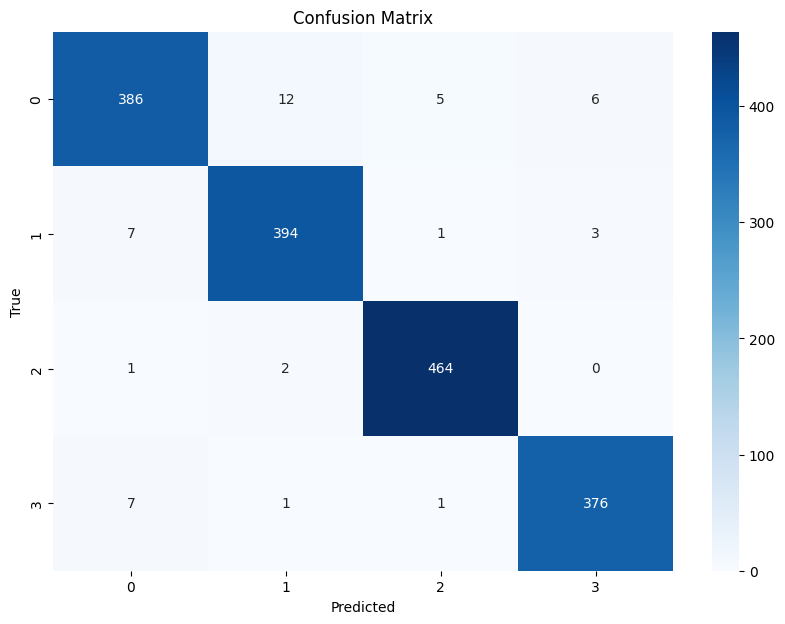

In [208]:
# Predpoveď na testovacích dátach
Y_pred = model.predict(X_test)
Y_pred_classes = Y_pred.argmax(axis=1)
Y_true = Y_test.argmax(axis=1)

# Vytvorenie konfúznej matice
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

# Vizuálne zobrazenie konfúznej matice
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [168]:
# Experimentovanie

# Experiment 1: Zmena learning rate
model_exp1 = create_model2()
model_exp1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_exp1 = model_exp1.fit(X_train, Y_train, epochs=50, validation_data=(X_val, Y_val), batch_size=32)

# Experiment 2: Zvýšenie počtu neurónov
model_exp2 = Sequential()
model_exp2.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model_exp2.add(Dense(64, activation='relu'))
model_exp2.add(Dense(Y_train.shape[1], activation='softmax'))
model_exp2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history_exp2 = model_exp2.fit(X_train, Y_train, epochs=50, validation_data=(X_val, Y_val), batch_size=32)


Epoch 1/50


c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3129 - loss: 1.3390 - val_accuracy: 0.6204 - val_loss: 1.1641
Epoch 2/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6585 - loss: 1.0772 - val_accuracy: 0.6613 - val_loss: 0.8763
Epoch 3/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7292 - loss: 0.7973 - val_accuracy: 0.8228 - val_loss: 0.6579
Epoch 4/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8499 - loss: 0.6105 - val_accuracy: 0.8847 - val_loss: 0.5286
Epoch 5/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8852 - loss: 0.5144 - val_accuracy: 0.9153 - val_loss: 0.4476
Epoch 6/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9072 - loss: 0.4392 - val_accuracy: 0.9195 - val_loss: 0.3957
Epoch 7/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9083 - loss: 0.4035 - val_accuracy: 0.9195 - val_loss: 0.3631
Epoch 8/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9103 - loss: 0.3715 - val_accuracy: 0.9321 - val_

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.9772 - loss: 0.0736
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


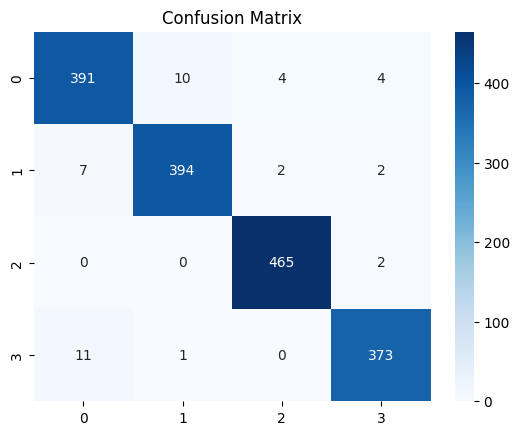

In [169]:
# Vyhodnotenie modelu
test_loss, test_acc = model.evaluate(X_test, Y_test)

# Konfúzna matica
Y_pred = model.predict(X_test)
cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

# Zobrazenie konfúznej matice
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()